In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp, odeint

<p align="center">🦋 🦋 🦋</p>

## The Lorenz System: WORK IN PROGRESS

As we move forward, let's recall that the cosine ODE we just explored was *not* state dependent. 

A direct result of that is that errors do not compound over time. But, many ODEs used in IVP solutions are state dependent. Depending on for how "long" the IVP is meant to process, that could be a big difference.

And, as we just saw, not all implementations are alike.

<p align="center">. . .</p>

Back to the books: This example is adopted from the book chapter's [Problems](https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter22.08-Summary-and-Problems.html#problems) section.

The Lorenz system is a set of three coupled, nonlinear differential equations:

$$\begin{align}
\frac{dx}{dt} &= \sigma(y - x) \\
\frac{dy}{dt} &= x(\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{align}$$

Where:
- $\sigma$ (sigma) is the Prandtl number
- $\rho$ (rho) is the Rayleigh number
- $\beta$ (beta) is related to the physical dimensions of the system

The homework problem suggests the initial values $\sigma = 10$, $\rho = 28$, and $\beta = 8/3$, which produce the famous "butterfly" strange attractor.

We will set up our system and conditions below, and once again we'll work between the two solvers.

In [2]:
# constants
sigma = 10
rho = 28
beta = 8/3

def lorenz_func_ivp(t, S):
    x, y, z = S
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

def lorenz_func_odeint(S, t):
    x, y, z = S
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# initial conditions
t0 = 0
t_eval = np.linspace(t0, 50, 51) # start at zero!
s0 = np.array([1, 2, 3])
# solve using solve_ivp
solution_ivp = solve_ivp(lorenz_func_ivp, 
                         [0, 1000], 
                         s0, 
                         t_eval=t_eval,
                         method='RK45'
                        )

# solve using odeint
solution_odeint = odeint(lorenz_func_odeint, s0, t_eval)

# sanity check: (should be [10, 23, -6])
dS_ivp = lorenz_func_ivp(t0, s0)
dS_odeint = lorenz_func_odeint(s0, t0)

print("dS_ivp sanity check at t = 0:")
print(dS_ivp)
print("--------------------------------")
print("dS_odeint sanity check at t = 0:")
print(dS_odeint)
print("--------------------------------")
print("solve_ivp solution, t = 1:")
print("T", "X", "Y", "Z")
print(solution_ivp.t[1], solution_ivp.y[0][1], solution_ivp.y[1][1], solution_ivp.y[2][1])
print("--------------------------------")
print("odeint solution, t = 1:")
print("T", "X", "Y", "Z")
print(1.0, solution_odeint[1][0], solution_odeint[1][1], solution_odeint[1][2])
print("--------------------------------")


dS_ivp sanity check at t = 0:
[np.int64(10), np.int64(23), np.float64(-6.0)]
--------------------------------
dS_odeint sanity check at t = 0:
[np.int64(10), np.int64(23), np.float64(-6.0)]
--------------------------------
solve_ivp solution, t = 1:
T X Y Z
1.0 -9.583611054055234 -7.742019787942493 30.550893768795497
--------------------------------
odeint solution, t = 1:
T X Y Z
1.0 -9.531818658681782 -7.620411135967427 30.526252209993295
--------------------------------


All right. We can see that we are off to the races: successfully, but in a way that is complex. Our two solvers diverge already by fractions that register up into the the tenths! 

Nonetheless, our base Lorenz functions seem to be constructed successfully, and we are ready to begin plotting them over some wider spaces.

To begin, let's take a look at our two solutions on their own.

num_steps: 44401


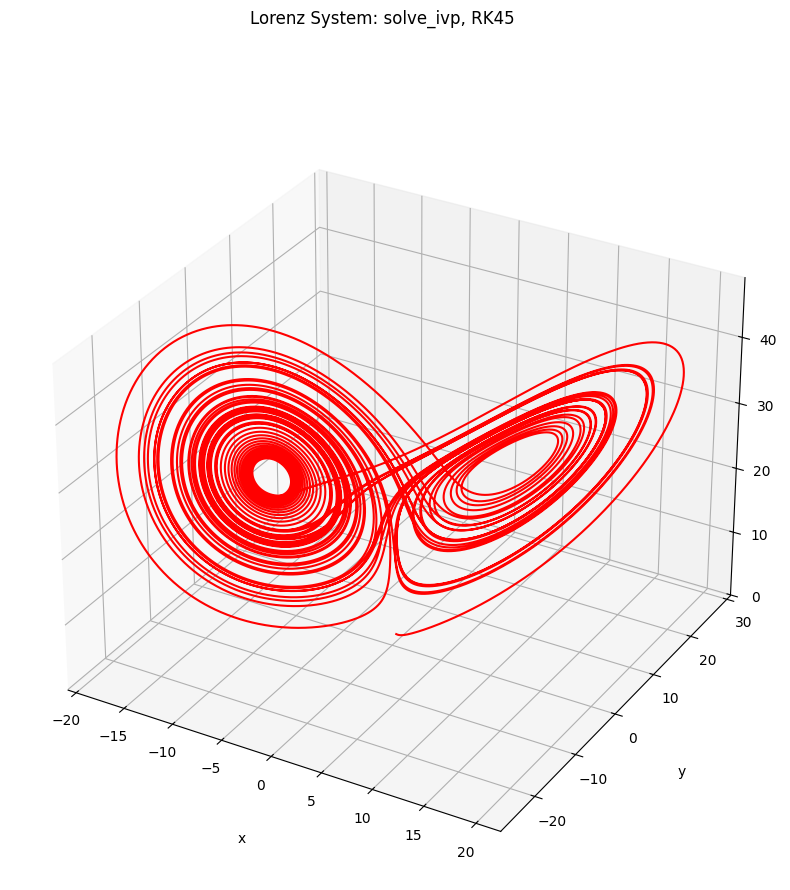

In [3]:
# the book suggests a different starting point for a plot
s0 = np.array([0, 1, 1.05])

# time parameters
inv_dt = 888 # points per unit time, easier to alter manually than dt.
             # inv_dt needs to stay large for smooth evaluation.
t0 = 0
tf = 50
rtol = 1e-6
atol = 1e-8

# build a time array
dt = 1.0 / inv_dt
num_steps = int((tf - t0) * inv_dt) + 1
print("num_steps:", num_steps)
t_eval = np.linspace(t0, tf, num_steps) 

# solve using solve_ivp
solution_ivp = solve_ivp(
    lorenz_func_ivp,
    [t0, tf],
    s0,
    t_eval=t_eval,        # adjust steps with inv_dt!
    method='RK45',
    max_step=1e-2,        
    rtol=rtol,
    atol=atol
)


fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
plt.suptitle("Lorenz System: solve_ivp, RK45")

ax.plot3D(solution_ivp.y[0], solution_ivp.y[1], solution_ivp.y[2], 'r')
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

plt.show()

The classic form of Lorenz appears quite happily here. Let's take a look at the same function processed through `odeint`.

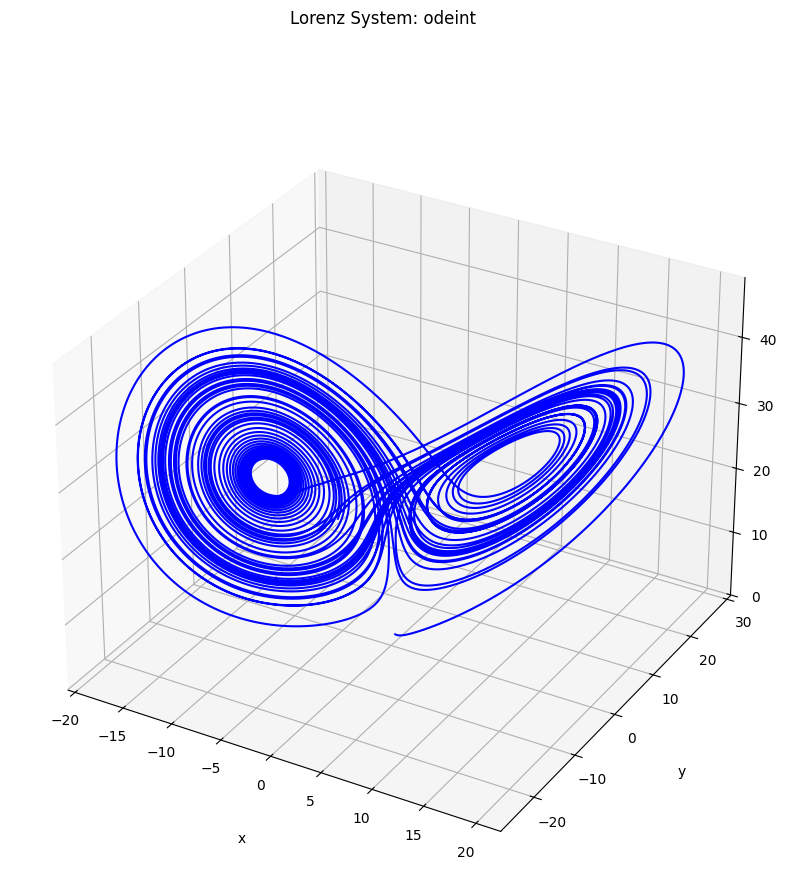

In [4]:
# solve using odeint
solution_odeint = odeint(lorenz_func_odeint, s0, t_eval)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
plt.suptitle("Lorenz System: odeint")

ax.plot3D(solution_odeint[:, 0],  # X values
          solution_odeint[:, 1],  # Y values
          solution_odeint[:, 2],  # Z values
          'b')                    # blue line

ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

plt.show()

Both forms are distinctly and clearly related, though also visibly divergent to some degree.

But, it's also important to remember that the "stock" version (no options) of `odeint` seems to be more accurate (at least in 2D) than the "vanilla" `solve_ivp`, which is what we have above.

Let's experiment a bit and see if we can illustrate the differences more clearly:

IVP shape: (44401, 3)
ODEINT shape: (44401, 3)


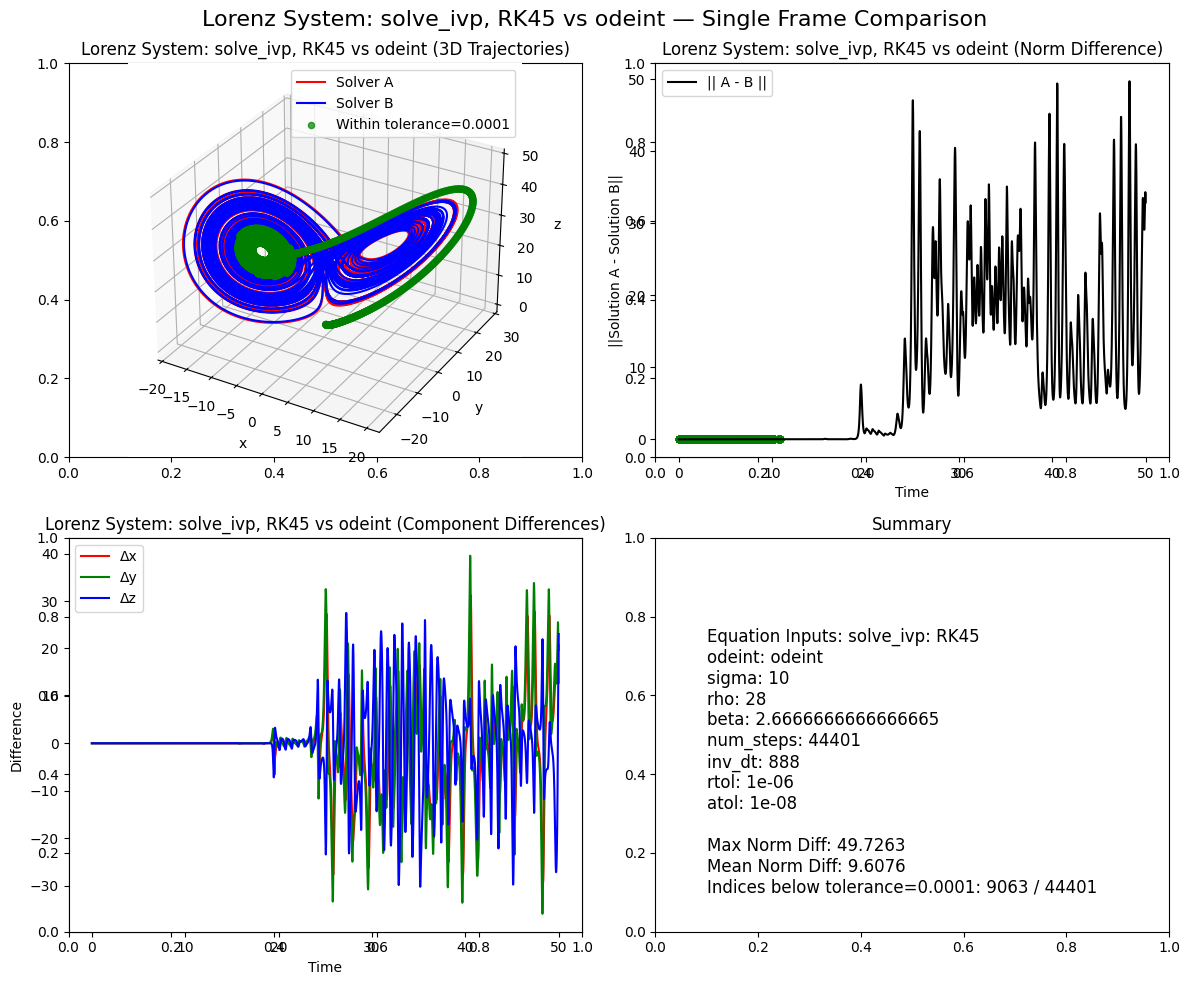

In [11]:
import os
import sys
divergence_static_path = os.path.abspath(os.path.join('divergence_static.py')) 
if divergence_static_path not in sys.path:
    sys.path.append(divergence_static_path)
from divergence_static import plot_ode_solves_comparison_static  # lengthy plotting code, elsewhere in this project repo.


tolerance = 1e-4

# before we do our comparison, it will be far easier to convert our two solutions into a format that can be plotted.
# our target format is a simple 3xN array, where N is the number of steps.
def convert_ivp_solve_to_n_3(ivp_solve):
    return ivp_solve.y.T  # T is our x, y, z arrays (numpy array)

def convert_odeint_solve_to_n_3(odeint_solve):
    return np.array(odeint_solve)  # numpy array

# double check to make sure our solutions are in the right format
print("IVP shape:", convert_ivp_solve_to_n_3(solution_ivp).shape)
print("ODEINT shape:", convert_odeint_solve_to_n_3(solution_odeint).shape)

# package up our params for the plot legend
legend_dict = {
    "solve_ivp": "RK45",
    "odeint": "odeint",
    "sigma": sigma,
    "rho": rho,
    "beta": beta,
    "num_steps": num_steps,
    "inv_dt": inv_dt,
    "rtol": rtol,
    "atol": atol
}

plt, axs = plot_ode_solves_comparison_static(
    convert_ivp_solve_to_n_3(solution_ivp),
    convert_odeint_solve_to_n_3(solution_odeint),
    inv_dt,
    tolerance=tolerance,
    title_prefix="Lorenz System: solve_ivp, RK45 vs odeint",
    legend_dict=legend_dict
)